In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fgvc-aircraft/val.csv
/kaggle/input/fgvc-aircraft/train.csv
/kaggle/input/fgvc-aircraft/test.csv
/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/example_evaluation.m
/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/vl_pr.m
/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/evaluation.m
/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/README.md
/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/vl_roc.m
/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/vl_argparse.m
/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/README.html
/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/vl_tpfp.m
/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images_manufacturer_train.txt
/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images_variant_val.txt
/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/f

In [ ]:
import pandas as pd
import numpy as np
import os

#  Base path
base_path = "/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data"

#  Load mapping files
def load_mapping(file_path, label_type):
    mapping = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(" ", 1)
            if len(parts) == 2:
                mapping.append((parts[0], parts[1]))
    return pd.DataFrame(mapping, columns=["image", label_type])

variant_df = load_mapping(f"{base_path}/images_variant_trainval.txt", "variant")
family_df = load_mapping(f"{base_path}/images_family_trainval.txt", "family")
maker_df = load_mapping(f"{base_path}/images_manufacturer_trainval.txt", "maker")

#  Merge labels on 'image'
df = variant_df.merge(family_df, on="image").merge(maker_df, on="image")

#  Group by variant to get canonical family & maker
hierarchy = df.groupby("variant")[["family", "maker"]].agg(lambda x: x.mode().iloc[0]).reset_index()

#  Create ID maps
variant_to_id = {v: i for i, v in enumerate(hierarchy["variant"].sort_values().unique())}
family_to_id = {f: i for i, f in enumerate(hierarchy["family"].sort_values().unique())}
maker_to_id = {m: i for i, m in enumerate(hierarchy["maker"].sort_values().unique())}

#  Map IDs
hierarchy["variant_id"] = hierarchy["variant"].map(variant_to_id)
hierarchy["family_id"] = hierarchy["family"].map(family_to_id)
hierarchy["maker_id"] = hierarchy["maker"].map(maker_to_id)

#  Optional: Create lookup dicts for later use
variant_to_family = hierarchy.set_index("variant_id")["family_id"].to_dict()
variant_to_maker = hierarchy.set_index("variant_id")["maker_id"].to_dict()

#  Save CSV
output_path = "/kaggle/working/hierarchy_full.csv"
hierarchy.to_csv(output_path, index=False)

#  Confirm
print(" hierarchy_full.csv saved with columns:", hierarchy.columns.tolist())
print(f" Classes: {len(variant_to_id)} variants, {len(family_to_id)} families, {len(maker_to_id)} makers")


In [ ]:
#  Step 1: Prepare variant to family/maker hierarchy and task splits
import pandas as pd
import os
import random
import json

# Path to original FGVC Aircraft data
base_path = "/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data"

# Load mapping from original trainval files
def load_mapping(file_path, label_type):
    mapping = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(" ", 1)
            if len(parts) == 2:
                mapping.append((parts[0], parts[1]))
    return pd.DataFrame(mapping, columns=["image", label_type])

variant_df = load_mapping(f"{base_path}/images_variant_trainval.txt", "variant")
family_df = load_mapping(f"{base_path}/images_family_trainval.txt", "family")
maker_df = load_mapping(f"{base_path}/images_manufacturer_trainval.txt", "maker")

# Merge into a full image-level dataframe
df = variant_df.merge(family_df, on="image").merge(maker_df, on="image")

# Get the variant-level hierarchy (unique mapping assumed)
hierarchy = df.groupby("variant")[["family", "maker"]].agg(lambda x: x.mode()[0]).reset_index()

# Save the full hierarchy
hierarchy_path = "/kaggle/working/hierarchy_full.csv"
hierarchy.to_csv(hierarchy_path, index=False)

#  Step 2: Split variants into 10 tasks randomly
variants = hierarchy["variant"].tolist()
random.seed(42)
random.shuffle(variants)

num_tasks = 10
variants_per_task = len(variants) // num_tasks

# Build task split dictionary with full hierarchy per variant
task_hierarchy = {}
for i in range(num_tasks):
    task_name = f"task_{i+1}"
    task_variants = variants[i*variants_per_task:(i+1)*variants_per_task]
    task_data = []
    for var in task_variants:
        fam = hierarchy[hierarchy["variant"] == var].iloc[0]["family"]
        mak = hierarchy[hierarchy["variant"] == var].iloc[0]["maker"]
        task_data.append({"variant": var, "family": fam, "manufacturer": mak})
    task_hierarchy[task_name] = task_data

# Save task split to JSON
with open("/kaggle/working/task_split.json", "w") as f:
    json.dump(task_hierarchy, f, indent=4)

print(" Task split with hierarchy saved to task_split.json")


In [4]:
!pip install scikit-image

In [ ]:
import os
import json
import torch
from PIL import Image
import numpy as np
from skimage.segmentation import slic
from skimage.util import img_as_float
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from tqdm import tqdm

#  Paths
base_path = "/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data"
img_dir = os.path.join(base_path, "images")
seg_dir = "/kaggle/working/segment_maps"
mapping_file = "/kaggle/working/mapping.txt"
task_split_path = "/kaggle/working/task_split.json"
variant_label_file = os.path.join(base_path, "images_variant_trainval.txt")

#  Create output directory
os.makedirs(seg_dir, exist_ok=True)
mapping = []

#  Step 1: Load task split
with open(task_split_path, "r") as f:
    task_split = json.load(f)

#  Step 2: Get list of allowed variants from all tasks
all_variants = set()
for task_data in task_split.values():
    for entry in task_data:
        all_variants.add(entry["variant"])

#  Step 3: Safe parser for image → variant mapping
def load_variant_mapping(file_path):
    records = []
    with open(file_path, "r") as f:
        for line in f:
            parts = line.strip().split(" ", 1)
            if len(parts) == 2:
                image, variant = parts
                records.append((image, variant))
    return pd.DataFrame(records, columns=["image", "variant"])

variant_df = load_variant_mapping(variant_label_file)
variant_df = variant_df[variant_df["variant"].isin(all_variants)].drop_duplicates().sort_values("image")

#  Step 4: Generate segment maps only for selected images
print(f" Generating superpixel maps for {len(variant_df)} images in task variant split...")

skipped = 0

for _, row in tqdm(variant_df.iterrows(), total=len(variant_df)):
    image_id = row["image"]
    img_path = os.path.join(img_dir, f"{image_id}.jpg")
    
    if not os.path.exists(img_path):
        skipped += 1
        continue

    try:
        image = Image.open(img_path).convert("RGB")
        resized = image.resize((224, 224))
        image_np = img_as_float(np.array(resized))

        segments = slic(image_np, n_segments=196, compactness=10, start_label=0)
        flat = segments.flatten()
        encoder = LabelEncoder()
        encoded = encoder.fit_transform(flat)
        normalized_segments = encoded.reshape(224, 224)

        seg_tensor = torch.from_numpy(normalized_segments).long()
        seg_save_path = os.path.join(seg_dir, image_id + ".pt")
        torch.save(seg_tensor, seg_save_path)

        mapping.append(f"{image_id} segment_maps/{image_id}.pt")
    except Exception as e:
        print(f" Skipping {image_id}: {e}")
        skipped += 1

#  Save mapping file
with open(mapping_file, "w") as f:
    f.writelines([line + "\n" for line in mapping])

#  Summary
print(f"\n Completed generation of superpixel maps.")
print(f" mapping.txt saved at {mapping_file}")
print(f"  Total segment maps created: {len(mapping)}")
print(f" Skipped or failed images: {skipped}")


In [6]:
!mkdir -p cast_models

In [ ]:
%%writefile cast_models/aircraft_dataset.py
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T

class AircraftHCASTDataset(Dataset):
    """
    Aircraft HCAST Dataset for Hierarchical Classification.
    Includes an optional flag to include segment maps or not.
    """
    def __init__(self, image_dir, label_file, image_split_file, mapping_file,
                 transform=None, use_segments=True, debug=False):
        self.image_dir = image_dir
        self.debug = debug
        self.use_segments = use_segments

        #  Default image transform
        self.transform = transform or T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])

        #  Load hierarchy
        self.hierarchy_df = pd.read_csv(label_file)
        self.variant_map = {
            row["variant"].strip().lower(): (row["variant_id"], row["family_id"], row["maker_id"])
            for _, row in self.hierarchy_df.iterrows()
        }
        self.num_variants = self.hierarchy_df["variant_id"].nunique()
        self.num_families = self.hierarchy_df["family_id"].nunique()
        self.num_makers = self.hierarchy_df["maker_id"].nunique()

        #  Segment path mapping
        if self.use_segments:
            with open(mapping_file, "r") as f:
                self.seg_dict = {
                    line.strip().split()[0]: line.strip().split()[1]
                    for line in f if line.strip()
                }

        #  Init sample storage
        self.samples = []
        self.variants = []
        self.families = []
        self.makers = []
        self.variant_names = []

        known_variants = set(self.variant_map.keys())

        with open(image_split_file, "r") as f:
            for line in f:
                if not line.strip():
                    continue
                try:
                    base_name, variant = line.strip().split(" ", 1)
                except ValueError:
                    if self.debug:
                        print(f" Malformed line: {line.strip()}")
                    continue

                variant_norm = variant.strip().lower()
                img_name = base_name + ".jpg"

                if variant_norm not in known_variants:
                    if self.debug:
                        print(f" Unknown variant: {variant}")
                    continue

                # Segment file check only if use_segments is True
                seg_rel_path = None
                if self.use_segments:
                    if base_name not in self.seg_dict:
                        if self.debug:
                            print(f" Missing segment map: {base_name}")
                        continue
                    seg_rel_path = self.seg_dict[base_name]
                    seg_abs_path = os.path.join("/kaggle/working", seg_rel_path)
                    if not os.path.exists(seg_abs_path):
                        if self.debug:
                            print(f" Segment file missing: {seg_abs_path}")
                        continue

                variant_id, family_id, maker_id = self.variant_map[variant_norm]
                self.samples.append((img_name, variant_norm, seg_rel_path))
                self.variants.append(variant_id)
                self.families.append(family_id)
                self.makers.append(maker_id)
                self.variant_names.append(variant.strip())

        if self.debug:
            print(f" Loaded {len(self.samples)} samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, variant_norm, seg_rel_path = self.samples[idx]
        img_path = os.path.join(self.image_dir, img_name)

        #  Load image
        image = Image.open(img_path).convert("RGB")
        image_tensor = self.transform(image)

        #  Load segment map if enabled
        segment_map = None
        if self.use_segments:
            seg_path = os.path.join("/kaggle/working", seg_rel_path)
            segment_map = torch.load(seg_path)

        #  Hierarchical labels
        variant_id, family_id, maker_id = self.variant_map[variant_norm]

        return {
            "image": image_tensor,
            "segments": segment_map,
            "variant": torch.tensor(variant_id, dtype=torch.long),
            "family": torch.tensor(family_id, dtype=torch.long),
            "maker": torch.tensor(maker_id, dtype=torch.long),
            "image_name": img_name
        }


Writing cast_models/aircraft_dataset.py


In [ ]:
%%writefile cast_models/cast.py
#  Imports
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

from timm.models.vision_transformer import VisionTransformer, _cfg
from timm.models.registry import register_model
from timm.models.layers import PatchEmbed, trunc_normal_

from cast_models.utils import segment_mean_nd
from cast_models.graph_pool import GraphPooling
from cast_models.modules import Pooling, ConvStem

_all_ = ['cast_small', 'cast_small_deep', 'cast_base', 'cast_base_deep']

class CAST(VisionTransformer):
    def __init__(self, *args, **kwargs):
        nb_classes = kwargs.pop('nb_classes', None)
        dropout_rate = kwargs.pop('dropout_rate', 0.1)
        assert nb_classes is not None, "You must provide nb_classes"

        depths = kwargs['depth']
        num_clusters = kwargs.pop('num_clusters', [64, 32, 16, 8])
        kwargs['depth'] = sum(depths)
        kwargs['drop_rate'] = dropout_rate
        kwargs['attn_drop_rate'] = dropout_rate
        kwargs['drop_path_rate'] = dropout_rate

        super().__init__(*args, **kwargs)

        if hasattr(self, 'dist_token'):
            del self.dist_token
        if hasattr(self, 'head_dist'):
            del self.head_dist

        if len(nb_classes) == 3:
            self.total_classes, self.num_family, self.num_manufacturer = nb_classes
        elif len(nb_classes) == 2:
            self.total_classes, self.num_family = nb_classes
            self.num_manufacturer = 0
        else:
            self.total_classes = nb_classes[0]
            self.num_family = 0
            self.num_manufacturer = 0

        #  Fixed classification heads (no dynamic expansion)
        self.head = nn.Linear(self.embed_dim, self.total_classes)
        self.family_head = nn.Linear(self.embed_dim, self.num_family) if self.num_family > 0 else nn.Identity()
        self.manufacturer_head = nn.Linear(self.embed_dim, self.num_manufacturer) if self.num_manufacturer > 0 else nn.Identity()

        patch_H, patch_W = self.patch_embed.grid_size
        num_patches = patch_H * patch_W
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, self.embed_dim))
        trunc_normal_(self.pos_embed, std=.02)

        cumsum = [0]
        for d in depths:
            cumsum.append(cumsum[-1] + d)
        assert sum(depths) == len(self.blocks)

        blocks, pools = [], []
        for i, d in enumerate(depths):
            blocks.append(self.blocks[cumsum[i]:cumsum[i + 1]])
            pool = Pooling(pool_block=GraphPooling(
                num_clusters=num_clusters[i],
                d_model=self.embed_dim,
                l2_normalize_for_fps=False
            ))
            if i == len(depths) - 1:
                for m in (pool.pool_block.fc1, pool.pool_block.fc2, pool.pool_block.centroid_fc):
                    for p in m.parameters():
                        p.requires_grad = False
            pools.append(pool)

        self.blocks1, self.pool1 = blocks[0], pools[0]
        self.blocks2, self.pool2 = blocks[1], pools[1]
        self.blocks3, self.pool3 = blocks[2], pools[2]
        self.blocks4, self.pool4 = blocks[3], pools[3]

    def _block_operations(self, x, cls_token, pad_mask, nn_block, pool_block, norm_block):
        cls_x = torch.cat([cls_token, x], dim=1)
        cls_x = nn_block(cls_x).type_as(x)
        cls_token, x = cls_x[:, :1], cls_x[:, 1:]

        cls_token, logit, centroid, new_mask, inds = pool_block(cls_token, x, pad_mask)
        out = norm_block(cls_x)[:, 0] if norm_block else cls_x[:, 0]
        return x, cls_token, logit, centroid, new_mask, inds, out

    def forward_features(self, x, y):
        x = self.patch_embed(x)
        N, H, W, C = x.shape
        y = F.interpolate(y.unsqueeze(1).float(), (H, W), mode='nearest').squeeze(1).long()
        ones = torch.ones((N, H, W, 1), device=x.device)
        avg = segment_mean_nd(ones, y).squeeze(-1)
        pad = avg <= 0.5
        x = segment_mean_nd(x, y)
        pos = segment_mean_nd(
            self.pos_embed[:, 1:].view(1, H, W, C).expand(N, -1, -1, -1), y
        )
        x = self.pos_drop(x + pos)
        cls = self.cls_token.expand(N, -1, -1) + self.pos_embed[:, :1]

        x, cls1, _, cent1, pad1, _, _ = self._block_operations(x, cls, pad, self.blocks1, self.pool1, None)
        x, cls2, _, cent2, pad2, _, out2 = self._block_operations(cent1, cls1, pad1, self.blocks2, self.pool2, None)
        x, cls3, _, cent3, pad3, _, out3 = self._block_operations(cent2, cls2, pad2, self.blocks3, self.pool3, None)
        _, _, _, _, _, _, out4 = self._block_operations(cent3, cls3, pad3, self.blocks4, self.pool4, self.norm)

        return out2, out3, out4

    def forward(self, x, y):
        out2, out3, out4 = self.forward_features(x, y)
        logits = self.head(out2)
        fam_logits = self.family_head(out3)
        man_logits = self.manufacturer_head(out4)
        return logits, fam_logits, man_logits

@register_model
def cast_small(pretrained=False, **kwargs):
    model = CAST(
        patch_size=8, embed_dim=384, num_clusters=[64, 32, 16, 8],
        depth=[3, 3, 3, 2], num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), embed_layer=ConvStem,
        **kwargs)
    model.default_cfg = _cfg()
    return model

@register_model
def cast_small_deep(pretrained=False, **kwargs):
    model = CAST(
        patch_size=8, embed_dim=384, num_clusters=[64, 32, 16, 8],
        depth=[6, 3, 3, 3], num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), embed_layer=ConvStem,
        **kwargs)
    model.default_cfg = _cfg()
    return model

@register_model
def cast_base(pretrained=False, **kwargs):
    model = CAST(
        patch_size=8, embed_dim=768, num_clusters=[64, 32, 16, 8],
        depth=[3, 3, 3, 2], num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), embed_layer=ConvStem,
        **kwargs)
    model.default_cfg = _cfg()
    return model

@register_model
def cast_base_deep(pretrained=False, **kwargs):
    model = CAST(
        patch_size=8, embed_dim=768, num_clusters=[64, 32, 16, 8],
        depth=[6, 3, 3, 3], num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), embed_layer=ConvStem,
        **kwargs)
    model.default_cfg = _cfg()
    return model

Writing cast_models/cast.py


In [9]:
%%writefile cast_models/graph_pool.py

import math
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F

from cast_models.utils import farthest_point_sampling
from cast_models.utils import segment_mean_nd


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % num_heads == 0, 'dim must be divisible by num_heads'
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):
    def __init__(self, dim, num_heads, qkv_bias=False, drop=0., attn_drop=0., norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm = norm_layer(dim)
        self.attn = Attention(dim, num_heads, qkv_bias, attn_drop, drop)
        self.drop_path = nn.Identity()
        self.bias = nn.Parameter(torch.zeros(dim).normal_(0, 1e-2))

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm(x)))
        x = x - x.mean(dim=1, keepdim=True) + self.bias.view(1, 1, -1)
        return x


class GraphPooling(nn.Module):
    def __init__(
        self,
        num_clusters=4,
        d_model=512,
        dropout=0.1,
        l2_normalize_for_fps=True,
        num_heads=12,
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6)
    ):
        super().__init__()
        self._num_clusters = num_clusters
        self._l2_normalize_for_fps = l2_normalize_for_fps

        self.centroid_fc = Block(d_model, num_heads, qkv_bias, norm_layer=norm_layer)
        self.fc1 = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.fc2 = nn.Sequential(
            nn.LayerNorm(d_model * 4),
            nn.Linear(d_model * 4, d_model)
        )

    def _fill_with_mean(self, src, mask):
        bs, sl, cs = src.shape
        if mask is not None:
            mean_src = valid_mean(src, ~mask).unsqueeze(1).type_as(src)
            fill_mask = mask.unsqueeze(2).expand(-1, -1, cs)
            filled_src = torch.where(fill_mask, mean_src.expand(-1, sl, -1), src)
        else:
            mean_src = src.mean(dim=1, keepdim=True)
            filled_src = src
        return filled_src, mean_src

    def forward(self, cls_token, src, mask=None):
        bs, sl, cs = src.shape

        if sl < self._num_clusters:
            raise ValueError(f"Too few tokens ({sl}) to sample {self._num_clusters} clusters.")

        filled_src, mean_src = self._fill_with_mean(src, mask)
        padded_src = torch.cat([mean_src, filled_src], dim=1)

        sampling_src = F.normalize(padded_src, dim=-1) if self._l2_normalize_for_fps else padded_src
        sampled_inds = farthest_point_sampling(sampling_src, self._num_clusters).clamp(0, sl - 1)
        unfold_inds = sampled_inds.unsqueeze(2).expand(-1, -1, cs)

        node_features = self.centroid_fc(src)
        centroid_feats = torch.gather(node_features, 1, unfold_inds)

        norm_node = F.normalize(node_features, dim=-1)
        norm_centroid = F.normalize(centroid_feats, dim=-1)
        logits = torch.matmul(norm_node, norm_centroid.transpose(1, 2)) * 5
        assignments = torch.softmax(logits, dim=-1)

        fc1_cls_src = self.fc1(torch.cat([cls_token, src], dim=1))
        fc1_cls, fc1_src = fc1_cls_src[:, :1], fc1_cls_src[:, 1:]

        normalizer = assignments.transpose(1, 2) @ torch.ones((bs, sl, 1), dtype=src.dtype, device=src.device)
        centroid = assignments.transpose(1, 2) @ fc1_src
        centroid = centroid / (normalizer + 1e-6)

        fc2_out = self.fc2(torch.cat([fc1_cls, centroid], dim=1))
        new_cls = fc2_out[:, :1, :] + cls_token
        new_centroid = fc2_out[:, 1:, :] + torch.gather(src, 1, unfold_inds)

        out = new_cls.squeeze(1)  # Final graph representation
        new_mask = None  # Placeholder for hierarchy-aware masking

        return new_cls, logits, new_centroid, new_mask, sampled_inds, out


def valid_mean(x, mask):
    mask = mask.type_as(x).unsqueeze(2)  # [B, N, 1]
    sum_mask = torch.clamp(mask.sum(dim=1), min=1)
    masked_x = x * mask
    mean_x = masked_x.sum(dim=1) / sum_mask
    return mean_x


Writing cast_models/graph_pool.py


In [10]:
%%writefile cast_models/modules.py
"""Define shared modules"""
import torch
import torch.nn as nn

from timm.layers.helpers import to_2tuple


class Pooling(nn.Module):

    def __init__(self, pool_block):
        super(Pooling, self).__init__()
        self.pool_block = pool_block

    def forward(self, cls_token, x, padding_mask=None):
        cls_token, pool_logit, centroid, new_mask, sampled_x_inds, out = self.pool_block(cls_token=cls_token, src=x, mask=padding_mask)

        pool_padding_mask = torch.zeros(
            (pool_logit.shape[0], pool_logit.shape[-1]),
            dtype=torch.bool,
            device=pool_logit.device)

        return cls_token, pool_logit, centroid, pool_padding_mask, sampled_x_inds


class ConvStem(nn.Module):
    def __init__(self, img_size=224, patch_size=8, in_chans=3, embed_dim=768, norm_layer=None, flatten=False, **kwargs):
        super().__init__()
        assert patch_size == 8, 'ConvStem only supports patch size of 8'
        assert embed_dim % 8 == 0, 'Embed dimension must be divisible by 2 for ConvStem'

        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.flatten = flatten

        stem = []
        input_dim, output_dim = in_chans, embed_dim // 8
        for l in range(4):
            stride = 2 if l < 3 else 1
            stem.append(nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1, bias=False))
            stem.append(nn.BatchNorm2d(output_dim))
            stem.append(nn.ReLU(inplace=True))
            input_dim = output_dim
            output_dim *= 2
        stem.append(nn.Conv2d(input_dim, embed_dim, kernel_size=1))
        self.proj = nn.Sequential(*stem)

        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        x = self.proj(x)
        if self.flatten:
            x = x.flatten(2).transpose(1, 2)
        else:
            x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        return x


class _BatchNorm1d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True):
        super(_BatchNorm1d, self).__init__()
        self.norm = nn.BatchNorm1d(num_features=num_features,
                                   eps=eps,
                                   momentum=momentum,
                                   affine=affine,
                                   track_running_stats=track_running_stats)

    def forward(self, x):
        return self.norm(x.transpose(1, 2)).transpose(1, 2)


class BlockFusion(nn.Module):
    def __init__(self, dim, block4_identity=True, discrete=True):
        super(BlockFusion, self).__init__()
        self.proj_blocks = self._make_proj_block(dim * 4, dim)
        self._discrete = discrete

    def _make_proj_block(self, in_dim, out_dim):
        return nn.Sequential(
            _BatchNorm1d(in_dim),
            nn.Dropout(0.2),
            nn.Linear(in_dim, out_dim, bias=True)
        )

    def _unpool(self, block, label):
        bs, ns, cs = block.shape
        label = label.unsqueeze(2).expand(-1, -1, cs)
        return torch.gather(block, 1, label)

    def _proj_block_operations(self, x, cls_token, proj_block):
        cls_x = torch.cat([cls_token, x], dim=1)
        cls_x = proj_block(cls_x).type_as(x)
        return cls_x[:, 1:, :], cls_x[:, :1, :]

    def forward(self, block1, block2, block3, block4,
                cls_token1, cls_token2, cls_token3, cls_token4,
                logit1_2, logit2_3, logit3_4):

        if not self._discrete:
            raise NotImplementedError("Only support discrete unpooling")

        label1_2 = torch.argmax(logit1_2, dim=-1)
        label2_3 = torch.argmax(logit2_3, dim=-1)
        label3_4 = torch.argmax(logit3_4, dim=-1)

        label1_3 = torch.gather(label2_3, 1, label1_2)
        label1_4 = torch.gather(label3_4, 1, label1_3)

        block2 = self._unpool(block2, label1_2)
        block3 = self._unpool(block3, label1_3)
        block4 = self._unpool(block4, label1_4)

        out_block = torch.cat([block1, block2, block3, block4], dim=-1)
        out_cls_token = torch.cat([cls_token1, cls_token2, cls_token3, cls_token4], dim=-1)

        out_block, out_cls_token = self._proj_block_operations(
            out_block, out_cls_token, self.proj_blocks)

        return out_block, out_cls_token


Writing cast_models/modules.py


In [ ]:
%%writefile cast_models/engine_hier.py
import math
import sys
from typing import Iterable, Optional

import torch
import torch.nn.functional as F

from timm.utils import accuracy, ModelEma
from cast_models.mixup_hier import Mixup
from cast_models.losses import DistillationLoss
from cast_models import utils

def train_one_epoch(
    model: torch.nn.Module,
    criterion: DistillationLoss,
    data_loader: Iterable,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    epoch: int,
    loss_scaler=None,
    max_norm: float = 0,
    model_ema: Optional[ModelEma] = None,
    mixup_fn: Optional[Mixup] = None,
    set_training_mode=True,
    args=None,
    task_classes: Optional[int] = None
):
    model.train(set_training_mode)
    metric_logger = utils.MetricLogger(delimiter=" ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{median:.6f} ({global_avg:.6f})'))
    header = f'Epoch: [{epoch}]'
    print_freq = 10

    if args.globalkl:
        gk_criterion = torch.nn.KLDivLoss(reduction='batchmean')

    for batch_idx, batch in enumerate(metric_logger.log_every(data_loader, print_freq, header)):
        samples = batch["image"].to(device, non_blocking=True)
        segments = batch["segments"].to(device, non_blocking=True)
        targets = batch["variant"].to(device, non_blocking=True)
        family_targets = batch["family"].to(device, non_blocking=True)
        mf_targets = batch.get("maker")
        if mf_targets is not None:
            mf_targets = mf_targets.to(device, non_blocking=True)

        if mixup_fn is not None:
            label_list = [targets, family_targets]
            if mf_targets is not None:
                label_list.append(mf_targets)
            samples, *mixed_targets = mixup_fn(samples, label_list)
            targets, family_targets = mixed_targets[:2]
            mf_targets = mixed_targets[2] if len(mixed_targets) == 3 else None

        model_output = model(samples, segments)
        if isinstance(model_output, tuple):
            if len(model_output) == 3:
                outputs, family_out, manu_out = model_output
            else:
                outputs, family_out = model_output
                manu_out = None
        else:
            raise ValueError("Model must return a tuple (variant, family [, maker])")

        if args.bce_loss:
            def to_soft(targets_tensor, num_classes):
                if targets_tensor.ndim == 2:
                    return targets_tensor
                return F.one_hot(targets_tensor, num_classes=num_classes).float()

            targets = to_soft(targets, outputs.shape[1])
            family_targets = to_soft(family_targets, family_out.shape[1])
            if mf_targets is not None:
                mf_targets = to_soft(mf_targets, manu_out.shape[1])
        else:
            if targets.ndim == 2:
                targets = targets.argmax(dim=1)
            if family_targets.ndim == 2:
                family_targets = family_targets.argmax(dim=1)
            if mf_targets is not None and mf_targets.ndim == 2:
                mf_targets = mf_targets.argmax(dim=1)

        #  Compute losses
        loss_species = criterion(samples, outputs, targets)
        loss_family = criterion(samples, family_out, family_targets)
        loss = loss_species + loss_family

        if mf_targets is not None:
            loss_manufacturer = criterion(samples, manu_out, mf_targets)
            loss += loss_manufacturer

        if args.globalkl:
            gk_outputs = [family_out, outputs]
            gk_targets = [family_targets, targets]
            if mf_targets is not None:
                gk_outputs.insert(0, manu_out)
                gk_targets.insert(0, mf_targets)

            gk_outputs = torch.cat(gk_outputs, dim=1)
            gk_outputs = F.log_softmax(gk_outputs, dim=1)

            norm_targets = []
            for out, tgt in zip([manu_out if mf_targets is not None else family_out, family_out, outputs][-len(gk_targets):], gk_targets):
                if tgt.ndim == 1:
                    tgt = F.one_hot(tgt, num_classes=out.shape[1]).float()
                norm_targets.append(tgt)
            gk_targets = F.normalize(torch.cat(norm_targets, dim=1), p=1, dim=1)

            gk_loss = gk_criterion(gk_outputs, gk_targets)
            loss += gk_loss * args.gk_weight

        optimizer.zero_grad(set_to_none=True)

        if loss_scaler is not None:
            loss_scaler(
                loss, optimizer,
                clip_grad=max_norm if max_norm > 0 else None,
                parameters=model.parameters(),
                create_graph=False
            )
        else:
            loss.backward()
            if max_norm > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()

        if model_ema is not None:
            model_ema.update(model)

        metric_logger.update(sploss=loss_species.item())
        metric_logger.update(fmloss=loss_family.item())
        if mf_targets is not None:
            metric_logger.update(mfloss=loss_manufacturer.item())
        if args.globalkl:
            metric_logger.update(gk_loss=gk_loss.item())
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

        with torch.no_grad():
            def get_hard(t):
                return t.argmax(dim=1) if t.ndim == 2 else t

            acc1, acc5 = accuracy(outputs, get_hard(targets), topk=(1, 5))
            fam_acc1 = accuracy(family_out, get_hard(family_targets), topk=(1,))[0]
            metric_logger.meters['acc1'].update(acc1.item(), n=samples.size(0))
            metric_logger.meters['acc5'].update(acc5.item(), n=samples.size(0))
            metric_logger.meters['family_acc1'].update(fam_acc1.item(), n=samples.size(0))

            if mf_targets is not None:
                manu_acc1 = accuracy(manu_out, get_hard(mf_targets), topk=(1,))[0]
                metric_logger.meters['manu_acc1'].update(manu_acc1.item(), n=samples.size(0))

        if epoch == 0 and batch_idx == 0:
            print("\n🔍 Gradient Check (First Batch Only):")
            for name, param in model.named_parameters():
                if param.requires_grad and param.grad is None:
                    print(f"🚩 {name}: No gradient!")
                elif param.requires_grad:
                    print(f"✅ {name}: grad norm = {param.grad.norm().item():.6f}")

    print(" Averaged stats:", metric_logger)
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}


Writing cast_models/engine_hier.py


In [12]:
%%writefile cast_models/utils.py
"""Utilility function for all.
"""
# This code is borrowed and re-implemented from:
# https://github.com/jyhjinghwang/SegSort/blob/master/network/segsort/vis_utils.py
# https://github.com/jyhjinghwang/SegSort/blob/master/network/segsort/common_utils.py

import torch
import torch.nn.functional as F
import time
import datetime
from collections import defaultdict, deque

def resize_labels(labels, size):
    """Helper function to resize labels.

    Args:
        labels: A long tensor of shape `[batch_size, height, width]`.

    Returns:
        A long tensor of shape `[batch_size, new_height, new_width]`.
    """
    n, h, w = labels.shape
    labels = F.interpolate(labels.view(n, 1, h, w).float(),
                           size=size,
                           mode='nearest')
    labels = labels.squeeze_(1).long()

    return labels


def calculate_principal_components(embeddings, num_components=3):
    """Calculates the principal components given the embedding features.

    Args:
      embeddings: A 2-D float tensor of shape `[num_pixels, embedding_dims]`.
      num_components: An integer indicates the number of principal
        components to return.

    Returns:
      A 2-D float tensor of shape `[num_pixels, num_components]`.
    """
    embeddings = embeddings - torch.mean(embeddings, 0, keepdim=True)
    _, _, v = torch.svd(embeddings)
    return v[:, :num_components]


def pca(embeddings, num_components=3, principal_components=None):
    """Conducts principal component analysis on the embedding features.

    This function is used to reduce the dimensionality of the embedding.

    Args:
        embeddings: An N-D float tensor with shape with the 
            last dimension as `embedding_dim`.
        num_components: The number of principal components.
        principal_components: A 2-D float tensor used to convert the
            embedding features to PCA'ed space, also known as the U matrix
            from SVD. If not given, this function will calculate the
            principal_components given inputs.

    Returns:
        A N-D float tensor with the last dimension as  `num_components`.
    """
    shape = embeddings.shape
    embeddings = embeddings.view(-1, shape[-1])

    if principal_components is None:
        principal_components = calculate_principal_components(
            embeddings, num_components)
    embeddings = torch.mm(embeddings, principal_components)

    new_shape = list(shape[:-1]) + [num_components]
    embeddings = embeddings.view(new_shape)

    return embeddings


def one_hot(labels, max_label=None):
    """Transform long labels into one-hot format.

    Args:
        labels: An N-D long tensor.

    Returns:
        An (N+1)-D long tensor.
    """
    if max_label is None:
        max_label = labels.max() + 1

    shape = labels.shape
    labels = labels.view(-1, 1)
    one_hot_labels = torch.zeros((labels.shape[0], max_label),
                                 dtype=torch.long,
                                 device=labels.device)
    one_hot_labels = one_hot_labels.scatter_(1, labels, 1)

    new_shape = list(shape) + [max_label]
    one_hot_labels = one_hot_labels.view(new_shape)

    return one_hot_labels


def normalize_embedding(embeddings, eps=1e-12):
    """Normalizes embedding by L2 norm.

    This function is used to normalize embedding so that the
    embedding features lie on a unit hypersphere.

    Args:
      embeddings: An N-D float tensor with feature embedding in
        the last dimension.

    Returns:
      An N-D float tensor with the same shape as input embedding
      with feature embedding normalized by L2 norm in the last
      dimension.
    """
    norm = torch.norm(embeddings, dim=-1, keepdim=True)
    norm = torch.where(torch.ge(norm, eps),
                       norm,
                       torch.ones_like(norm).mul_(eps))
    return embeddings / norm


def segment_mean(x, index):
    """
    Compute the mean of elements in `x` grouped by `index`.

    Args:
        x: Tensor of shape [N, D] or any shape where last dimension is feature dim.
        index: LongTensor of shape [N], must be >= 0 and contiguous group indices.

    Returns:
        Tensor of shape [num_segments, D] where each row is mean of the segment.
    """
    # Ensure x is 2D
    x = x.reshape(-1, x.shape[-1])  # Use reshape instead of view for safety
    index = index.reshape(-1)

    # Check for negative indices which would cause runtime error
    if torch.any(index < 0):
        raise ValueError("segment_mean error: `index` contains negative values.")

    max_index = index.max().item() + 1  # Get total number of segments

    sum_x = torch.zeros((max_index, x.shape[-1]), dtype=x.dtype, device=x.device)
    count = torch.zeros((max_index,), dtype=x.dtype, device=x.device)

    count = count.scatter_add(0, index, torch.ones_like(index, dtype=x.dtype))
    index_2d = index.unsqueeze(1).expand(-1, x.shape[-1])
    sum_x = sum_x.scatter_add(0, index_2d, x)

    # Avoid divide-by-zero (if any count is 0)
    count = torch.clamp(count, min=1.0)
    mean_x = sum_x / count.unsqueeze(1)

    return mean_x


def segment_mean_nd(x, index, start_dim=-3, end_dim=-2):
    """
    Batched segment-wise mean pooling for N-D tensors using labels.

    Args:
        x: Float tensor of shape [B, ..., H, W, C] where C is feature dim.
        index: Long tensor of shape [B, ..., H, W] containing segment labels.
        start_dim: Start of spatial dims (default: -3 for [B, H, W, C]).
        end_dim: End of spatial dims (default: -2).

    Returns:
        mean_x: Float tensor of shape [B, K, C] where K = number of segments.
    """
    # Normalize dims
    if start_dim < 0:
        start_dim = x.dim() + start_dim
    if end_dim < 0:
        end_dim = x.dim() + end_dim

    batch_dims = list(x.shape[:start_dim])
    C = x.shape[-1]

    # Flatten batch + spatial dims
    x = x.reshape(-1, C)
    index = index.reshape(-1)

    if torch.any(index < 0):
        raise ValueError("segment_mean_nd error: `index` contains negative values.")

    B = batch_dims[0]
    max_seg_id = index.max().item() + 1

    # Encode batch dimension into segment index to keep segments separate per sample
    batch_ids = torch.arange(B, device=index.device).repeat_interleave(index.numel() // B)
    global_index = batch_ids * max_seg_id + index

    # Use the safe segment_mean implementation
    mean_x = segment_mean(x, global_index)

    # Fix output shape: [B, max_seg_id, C]
    expected_len = B * max_seg_id
    if mean_x.shape[0] < expected_len:
        mean_x = F.pad(mean_x, (0, 0, 0, expected_len - mean_x.shape[0]))

    mean_x = mean_x.reshape(B, max_seg_id, C)
    return mean_x


def farthest_point_sampling(x, k):
    """
    x: (B, N, C) tensor
    k: number of samples
    Return: (B, k) indices
    """
    B, N, C = x.shape
    indices = torch.zeros((B, k), dtype=torch.long, device=x.device)
    farthest = torch.randint(0, N, (B,), dtype=torch.long, device=x.device)
    distances = torch.full((B, N), float('inf'), device=x.device)

    for i in range(k):
        indices[:, i] = farthest
        centroid = x[torch.arange(B), farthest].unsqueeze(1)  # (B, 1, C)
        dist = ((x - centroid) ** 2).sum(-1)  # (B, N)
        mask = dist < distances
        distances[mask] = dist[mask]
        farthest = distances.max(-1)[1]

    return indices

class NativeScalerWithGradNormCount:
    def __init__(self):
        self.scaler = torch.cuda.amp.GradScaler()

    def __call__(self, loss, optimizer, clip_grad=None, parameters=None, create_graph=False):
        self.scaler.scale(loss).backward(create_graph=create_graph)
        if clip_grad is not None:
            self.scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(parameters, clip_grad)
        self.scaler.step(optimizer)
        self.scaler.update()
        optimizer.zero_grad()


class SmoothedValue:
    """Track a series of values and provide access to smoothed values over a window."""
    def __init__(self, window_size=20, fmt=None):
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt if fmt else "{median:.4f} ({global_avg:.4f})"

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count if self.count > 0 else 0

    def __str__(self):
        return self.fmt.format(median=self.median, global_avg=self.global_avg)


class MetricLogger:
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            self.meters[k].update(v)

    def __str__(self):
        return self.delimiter.join(f"{name}: {meter}" for name, meter in self.meters.items())

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        start_time = time.time()
        for obj in iterable:
            yield obj
            if i % print_freq == 0:
                elapsed = time.time() - start_time
                print_str = [header or "", f"[{i}/{len(iterable)}]"]
                print_str += [f"{name}: {str(meter)}" for name, meter in self.meters.items()]
                print_str.append(f"time: {elapsed:.2f}s")
                print(self.delimiter.join(print_str))
            i += 1

Writing cast_models/utils.py


In [ ]:
%%writefile cast_models/mixup_hier.py
import numpy as np
import torch

def one_hot(x, num_classes, on_value=1., off_value=0.):
    x = x.long().view(-1, 1)
    if torch.any(x < 0) or torch.any(x >= num_classes):
        print(f" ERROR: Found out-of-bound label in one_hot! Min: {x.min().item()}, Max: {x.max().item()}, Num classes: {num_classes}")
        raise ValueError("Labels out of range for one_hot encoding.")
    return torch.full((x.size()[0], num_classes), off_value, device=x.device).scatter_(1, x, on_value)

def mixup_target(target, num_classes, lam=1., smoothing=0.0):
    off_value = smoothing / num_classes
    on_value = 1. - smoothing + off_value
    y1 = one_hot(target, num_classes, on_value=on_value, off_value=off_value)
    y2 = one_hot(target.flip(0), num_classes, on_value=on_value, off_value=off_value)
    return y1 * lam + y2 * (1. - lam)

def rand_bbox(img_shape, lam, margin=0., count=None):
    ratio = np.sqrt(1 - lam)
    img_h, img_w = img_shape[-2:]
    cut_h, cut_w = int(img_h * ratio), int(img_w * ratio)
    margin_y, margin_x = int(margin * cut_h), int(margin * cut_w)
    cy = np.random.randint(0 + margin_y, img_h - margin_y, size=count)
    cx = np.random.randint(0 + margin_x, img_w - margin_x, size=count)
    yl = np.clip(cy - cut_h // 2, 0, img_h)
    yh = np.clip(cy + cut_h // 2, 0, img_h)
    xl = np.clip(cx - cut_w // 2, 0, img_w)
    xh = np.clip(cx + cut_w // 2, 0, img_w)
    return yl, yh, xl, xh

def rand_bbox_minmax(img_shape, minmax, count=None):
    assert len(minmax) == 2
    img_h, img_w = img_shape[-2:]
    cut_h = np.random.randint(int(img_h * minmax[0]), int(img_h * minmax[1]), size=count)
    cut_w = np.random.randint(int(img_w * minmax[0]), int(img_w * minmax[1]), size=count)
    yl = np.random.randint(0, img_h - cut_h, size=count)
    xl = np.random.randint(0, img_w - cut_w, size=count)
    yu = yl + cut_h
    xu = xl + cut_w
    return yl, yu, xl, xu

def cutmix_bbox_and_lam(img_shape, lam, ratio_minmax=None, correct_lam=True, count=None):
    if ratio_minmax is not None:
        yl, yu, xl, xu = rand_bbox_minmax(img_shape, ratio_minmax, count=count)
    else:
        yl, yu, xl, xu = rand_bbox(img_shape, lam, count=count)
    if correct_lam or ratio_minmax is not None:
        bbox_area = (yu - yl) * (xu - xl)
        lam = 1. - bbox_area / float(img_shape[-2] * img_shape[-1])
    return (yl, yu, xl, xu), lam

class Mixup:
    def __init__(self, mixup_alpha=1., cutmix_alpha=0., cutmix_minmax=None, prob=1.0, switch_prob=0.5,
                 mode='batch', correct_lam=True, label_smoothing=0.1, num_classes=[100, 70, 30]):
        self.mixup_alpha = mixup_alpha
        self.cutmix_alpha = cutmix_alpha
        self.cutmix_minmax = cutmix_minmax
        if self.cutmix_minmax is not None:
            assert len(self.cutmix_minmax) == 2
            self.cutmix_alpha = 1.0
        self.mix_prob = prob
        self.switch_prob = switch_prob
        self.label_smoothing = label_smoothing
        self.num_classes = num_classes
        self.mode = mode
        self.correct_lam = correct_lam
        self.mixup_enabled = True

    def _params_per_elem(self, batch_size):
        lam = np.ones(batch_size, dtype=np.float32)
        use_cutmix = np.zeros(batch_size, dtype=bool)
        if self.mixup_enabled:
            if self.mixup_alpha > 0. and self.cutmix_alpha > 0.:
                use_cutmix = np.random.rand(batch_size) < self.switch_prob
                lam_mix = np.where(
                    use_cutmix,
                    np.random.beta(self.cutmix_alpha, self.cutmix_alpha, size=batch_size),
                    np.random.beta(self.mixup_alpha, self.mixup_alpha, size=batch_size))
            elif self.mixup_alpha > 0.:
                lam_mix = np.random.beta(self.mixup_alpha, self.mixup_alpha, size=batch_size)
            elif self.cutmix_alpha > 0.:
                use_cutmix = np.ones(batch_size, dtype=bool)
                lam_mix = np.random.beta(self.cutmix_alpha, self.cutmix_alpha, size=batch_size)
            else:
                raise ValueError("Either mixup_alpha or cutmix_alpha must be > 0")
            lam = np.where(np.random.rand(batch_size) < self.mix_prob, lam_mix.astype(np.float32), lam)
        return lam, use_cutmix

    def _params_per_batch(self):
        lam = 1.
        use_cutmix = False
        if self.mixup_enabled and np.random.rand() < self.mix_prob:
            if self.mixup_alpha > 0. and self.cutmix_alpha > 0.:
                use_cutmix = np.random.rand() < self.switch_prob
                lam_mix = np.random.beta(self.cutmix_alpha, self.cutmix_alpha) if use_cutmix else \
                    np.random.beta(self.mixup_alpha, self.mixup_alpha)
            elif self.mixup_alpha > 0.:
                lam_mix = np.random.beta(self.mixup_alpha, self.mixup_alpha)
            elif self.cutmix_alpha > 0.:
                use_cutmix = True
                lam_mix = np.random.beta(self.cutmix_alpha, self.cutmix_alpha)
            else:
                raise ValueError("Either mixup_alpha or cutmix_alpha must be > 0")
            lam = float(lam_mix)
        return lam, use_cutmix

    def _mix_batch(self, x):
        lam, use_cutmix = self._params_per_batch()
        if lam == 1.:
            return 1.
        if use_cutmix:
            (yl, yh, xl, xh), lam = cutmix_bbox_and_lam(
                x.shape, lam, ratio_minmax=self.cutmix_minmax, correct_lam=self.correct_lam)
            x[:, :, yl:yh, xl:xh] = x.flip(0)[:, :, yl:yh, xl:xh]
        else:
            x_flipped = x.flip(0).mul_(1. - lam)
            x.mul_(lam).add_(x_flipped)
        return lam

    def __call__(self, x, target_list):
        assert len(x) % 2 == 0, 'Batch size should be even for mixup'
        lam = self._mix_batch(x) if self.mode == 'batch' else 1.0  # You can expand support for 'elem' or 'pair' if needed
        targets_encoded = []

        for i, targets in enumerate(target_list):
            targets_encoded.append(mixup_target(targets, self.num_classes[i], lam, self.label_smoothing))

        return (x, *targets_encoded)


Writing cast_models/mixup_hier.py


In [ ]:
%%writefile cast_models/losses.py
# Copyright (c) 2015-present, Facebook, Inc.
# All rights reserved.
"""
Implements the knowledge distillation loss
"""
import torch
from torch.nn import functional as F


class DistillationLoss(torch.nn.Module):
    """
    This module wraps a standard criterion and adds an extra knowledge distillation loss by
    taking a teacher model prediction and using it as additional supervision.
    """
    def __init__(self, base_criterion: torch.nn.Module, teacher_model: torch.nn.Module,
                 distillation_type: str, alpha: float, tau: float):
        super().__init__()
        self.base_criterion = base_criterion
        self.teacher_model = teacher_model
        assert distillation_type in ['none', 'soft', 'hard']
        self.distillation_type = distillation_type
        self.alpha = alpha
        self.tau = tau

    def forward(self, inputs, outputs, labels):
        """
        Args:
            inputs: The original inputs that are fed to the teacher model
            outputs: the outputs of the model to be trained. It is expected to be
                either a Tensor, or a Tuple[Tensor, Tensor], with the original output
                in the first position and the distillation predictions as the second output
            labels: the labels for the base criterion (can be hard or soft targets)
        """
        outputs_kd = None
        if not isinstance(outputs, torch.Tensor):
            # assume that the model outputs a tuple of [outputs, outputs_kd]
            outputs, outputs_kd = outputs

        #  Handle BCE vs CE correctly with soft labels
        if labels.ndim == 2:
            if isinstance(self.base_criterion, torch.nn.CrossEntropyLoss):
                raise ValueError("CrossEntropyLoss does not support soft targets. Use BCEWithLogitsLoss instead.")
            base_loss = self.base_criterion(outputs, labels)
        else:
            base_loss = self.base_criterion(outputs, labels)

        if self.distillation_type == 'none':
            return base_loss

        if outputs_kd is None:
            raise ValueError("When knowledge distillation is enabled, the model is "
                             "expected to return a Tuple[Tensor, Tensor] with the output of the "
                             "class_token and the dist_token")

        # don't backprop through the teacher
        with torch.no_grad():
            teacher_outputs = self.teacher_model(inputs)

        if self.distillation_type == 'soft':
            T = self.tau
            distillation_loss = F.kl_div(
                F.log_softmax(outputs_kd / T, dim=1),
                F.log_softmax(teacher_outputs / T, dim=1),
                reduction='sum',
                log_target=True
            ) * (T * T) / outputs_kd.numel()

        elif self.distillation_type == 'hard':
            distillation_loss = F.cross_entropy(outputs_kd, teacher_outputs.argmax(dim=1))

        loss = base_loss * (1 - self.alpha) + distillation_loss * self.alpha
        return loss


Writing cast_models/losses.py


In [ ]:
import pandas as pd
import numpy as np
import os

#  Base path
base_path = "/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data"

#  Load mapping files
def load_mapping(file_path, label_type):
    mapping = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(" ", 1)
            if len(parts) == 2:
                mapping.append((parts[0], parts[1]))
    return pd.DataFrame(mapping, columns=["image", label_type])

variant_df = load_mapping(f"{base_path}/images_variant_trainval.txt", "variant")
family_df = load_mapping(f"{base_path}/images_family_trainval.txt", "family")
maker_df = load_mapping(f"{base_path}/images_manufacturer_trainval.txt", "maker")

#  Merge labels on 'image'
df = variant_df.merge(family_df, on="image").merge(maker_df, on="image")

#  Group by variant to get canonical family & maker
hierarchy = df.groupby("variant")[["family", "maker"]].agg(lambda x: x.mode().iloc[0]).reset_index()

#  Create ID maps
variant_to_id = {v: i for i, v in enumerate(hierarchy["variant"].sort_values().unique())}
family_to_id = {f: i for i, f in enumerate(hierarchy["family"].sort_values().unique())}
maker_to_id = {m: i for i, m in enumerate(hierarchy["maker"].sort_values().unique())}

#  Map IDs
hierarchy["variant_id"] = hierarchy["variant"].map(variant_to_id)
hierarchy["family_id"] = hierarchy["family"].map(family_to_id)
hierarchy["maker_id"] = hierarchy["maker"].map(maker_to_id)

#  Optional: Create lookup dicts for later use
variant_to_family = hierarchy.set_index("variant_id")["family_id"].to_dict()
variant_to_maker = hierarchy.set_index("variant_id")["maker_id"].to_dict()

output_path = "/kaggle/working/hierarchy_full.csv"
hierarchy.to_csv(output_path, index=False)


print("✅ hierarchy_full.csv saved with columns:", hierarchy.columns.tolist())
print(f"🔢 Classes: {len(variant_to_id)} variants, {len(family_to_id)} families, {len(maker_to_id)} makers")


/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loaded dataset: 6667 samples
Total classes: Variant=100, Family=70, Maker=30

--- Training on Task 1 (667 samples) ---


/kaggle/working/cast_models/utils.py:231: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


Early stopping triggered!
✅ Model for task_1 saved as hcast_task1.pth
CUMULATIVE ACCURACY after Task 1: Variant@1=61.17% | Family@1=59.97% | Maker@1=69.27%

--- Training on Task 2 (668 samples) ---
Early stopping triggered!
✅ Model for task_2 saved as hcast_task2.pth
CUMULATIVE ACCURACY after Task 2: Variant@1=29.59% | Family@1=27.27% | Maker@1=34.61%

--- Training on Task 3 (666 samples) ---
Early stopping triggered!
✅ Model for task_3 saved as hcast_task3.pth
CUMULATIVE ACCURACY after Task 3: Variant@1=22.99% | Family@1=26.34% | Maker@1=32.98%

--- Training on Task 4 (664 samples) ---
Early stopping triggered!
✅ Model for task_4 saved as hcast_task4.pth
CUMULATIVE ACCURACY after Task 4: Variant@1=20.45% | Family@1=23.23% | Maker@1=34.41%

--- Training on Task 5 (669 samples) ---
Early stopping triggered!
✅ Model for task_5 saved as hcast_task5.pth
CUMULATIVE ACCURACY after Task 5: Variant@1=16.41% | Family@1=20.10% | Maker@1=30.20%

--- Training on Task 6 (666 samples) ---
Early stop

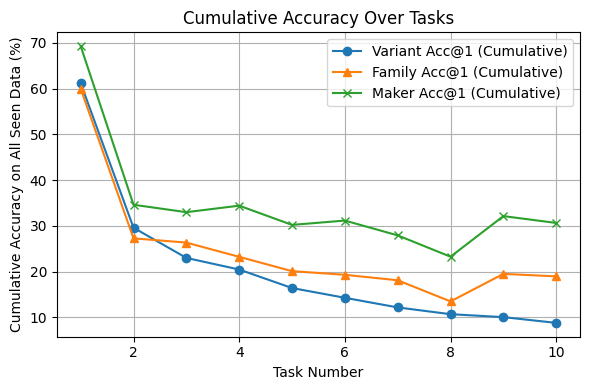

In [ ]:
import os
import json
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from cast_models.aircraft_dataset import AircraftHCASTDataset
from cast_models.mixup_hier import Mixup
from cast_models.cast import cast_small
from cast_models.utils import NativeScalerWithGradNormCount

# Configuration
class Args:
    lr = 3e-4
    epochs = 200
    weight_decay = 0.05
    num_workers = 4
    mixup = 0.2
    cutmix = 0.2
    bce_loss = False
    globalkl = True
    gk_weight = 1.5
    warmup_epochs = 20
    min_lr = 1e-6
    early_stopping_patience = 15

args = Args()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utils
class SoftTargetCrossEntropy(nn.Module):
    def forward(self, logits, soft_targets):
        return torch.sum(-soft_targets * F.log_softmax(logits, dim=-1), dim=-1).mean()

class RemapLabels(torch.utils.data.Dataset):
    def __init__(self, subset, variant_map, family_map, maker_map):
        self.subset = subset
        self.variant_map = variant_map
        self.family_map = family_map
        self.maker_map = maker_map

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        item = self.subset[idx]
        item["variant"] = torch.tensor(self.variant_map[int(item["variant"])], dtype=torch.long)
        item["family"]  = torch.tensor(self.family_map[int(item["family"])],   dtype=torch.long)
        item["maker"]   = torch.tensor(self.maker_map[int(item["maker"])],     dtype=torch.long)
        return item

# Load task split
with open("task_split.json", "r") as f:
    task_split = json.load(f)

# Transforms
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandAugment(num_ops=9, magnitude=5),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

# Dataset
full_dataset = AircraftHCASTDataset(
    image_dir="/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images",
    label_file="hierarchy_full.csv",
    image_split_file="/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images_variant_trainval.txt",
    mapping_file="mapping.txt",
    transform=transform
)
print(f"Loaded dataset: {len(full_dataset)} samples")

# Label remapping
global_var_map = {orig: i for i, orig in enumerate(sorted(set(full_dataset.variants)))}
global_fam_map = {orig: i for i, orig in enumerate(sorted(set(full_dataset.families)))}
global_man_map = {orig: i for i, orig in enumerate(sorted(set(full_dataset.makers)))}
nb_classes = [len(global_var_map), len(global_fam_map), len(global_man_map)]
print(f"Total classes: Variant={nb_classes[0]}, Family={nb_classes[1]}, Maker={nb_classes[2]}")

# Model setup
model = cast_small(nb_classes=nb_classes).to(device)
optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
loss_scaler = NativeScalerWithGradNormCount()

acc1_list, fam_acc_list, manu_acc_list = [], [], []
cumulative_eval_indices = []

for task_idx in range(1, 11):
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=args.epochs - args.warmup_epochs, eta_min=args.min_lr
    )

    task_name = f"task_{task_idx}"
    variants_in_task = {v["variant"] for v in task_split[task_name]}
    orig_variant_ids = {
        full_dataset.variants[i]
        for i, name in enumerate(full_dataset.variant_names)
        if name in variants_in_task
    }
    current_task_indices = [i for i, vid in enumerate(full_dataset.variants) if vid in orig_variant_ids]
    cumulative_eval_indices.extend(current_task_indices)

    train_subset = Subset(full_dataset, current_task_indices)
    train_remapped = RemapLabels(train_subset, global_var_map, global_fam_map, global_man_map)
    train_loader = DataLoader(train_remapped, batch_size=128, shuffle=True,
                              num_workers=args.num_workers, drop_last=True, pin_memory=True)

    mixup_fn = Mixup(mixup_alpha=args.mixup, cutmix_alpha=args.cutmix,
                     num_classes=nb_classes, label_smoothing=0.1, mode="batch")
    loss_var = SoftTargetCrossEntropy()
    loss_fam = SoftTargetCrossEntropy()
    loss_man = SoftTargetCrossEntropy()

    best_val_acc = 0
    patience_counter = 0

    print(f"\n--- Training on Task {task_idx} ({len(train_subset)} samples) ---")
    model.train()
    for epoch in range(args.epochs):
        if epoch < args.warmup_epochs:
            new_lr = args.lr * (epoch + 1) / args.warmup_epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = new_lr
        else:
            lr_scheduler.step()

        epoch_loss = 0
        for batch in train_loader:
            imgs = batch["image"].to(device)
            segs = batch["segments"].to(device)
            tgt_v = batch["variant"].to(device)
            tgt_f = batch["family"].to(device)
            tgt_m = batch["maker"].to(device)

            imgs, mt_v, mt_f, mt_m = mixup_fn(imgs, [tgt_v, tgt_f, tgt_m])
            out_v, out_f, out_m = model(imgs, segs)

            l_v = loss_var(out_v, mt_v)
            l_f = loss_fam(out_f, mt_f)
            l_m = loss_man(out_m, mt_m)
            loss = l_v + l_f + args.gk_weight * l_m

            optimizer.zero_grad()
            loss_scaler(loss, optimizer, parameters=model.parameters())
            epoch_loss += loss.item()

        # Early stopping logic (on training loss — you can switch to validation accuracy if needed)
        avg_epoch_loss = epoch_loss / len(train_loader)
        if avg_epoch_loss < best_val_acc or epoch == 0:
            best_val_acc = avg_epoch_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= args.early_stopping_patience:
                print("Early stopping triggered!")
                break

    # Evaluation on cumulative seen tasks
    model.eval()
    correct_v = correct_f = correct_m = total = 0
    eval_subset = Subset(full_dataset, cumulative_eval_indices)
    eval_remapped = RemapLabels(eval_subset, global_var_map, global_fam_map, global_man_map)
    eval_loader = DataLoader(eval_remapped, batch_size=128, shuffle=False,
                             num_workers=args.num_workers, drop_last=False, pin_memory=True)

    with torch.no_grad():
        for batch in eval_loader:
            imgs = batch["image"].to(device)
            segs = batch["segments"].to(device)
            tgt_v = batch["variant"].to(device)
            tgt_f = batch["family"].to(device)
            tgt_m = batch["maker"].to(device)

            out_v, out_f, out_m = model(imgs, segs)
            pred_v = out_v.argmax(1)
            pred_f = out_f.argmax(1)
            pred_m = out_m.argmax(1)

            total += imgs.size(0)
            correct_v += (pred_v == tgt_v).sum().item()
            correct_f += (pred_f == tgt_f).sum().item()
            correct_m += (pred_m == tgt_m).sum().item()

    acc1_list.append(correct_v / total * 100)
    fam_acc_list.append(correct_f / total * 100)
    manu_acc_list.append(correct_m / total * 100)
    
    model_path = f"hcast_task{task_idx}.pth"
    torch.save(model.state_dict(), model_path)
    print(f" Model for {task_name} saved as {model_path}")

    print(f"CUMULATIVE ACCURACY after Task {task_idx}: "
          f"Variant@1={acc1_list[-1]:.2f}% | Family@1={fam_acc_list[-1]:.2f}% | Maker@1={manu_acc_list[-1]:.2f}%")

# Plot accuracy
tasks = np.arange(1, len(acc1_list)+1)
plt.figure(figsize=(6,4))
plt.plot(tasks, acc1_list, marker='o', label='Variant Acc@1 (Cumulative)')
plt.plot(tasks, fam_acc_list, marker='^', label='Family Acc@1 (Cumulative)')
plt.plot(tasks, manu_acc_list, marker='x', label='Maker Acc@1 (Cumulative)')
plt.xlabel("Task Number")
plt.ylabel("Cumulative Accuracy on All Seen Data (%)")
plt.title("Cumulative Accuracy Over Tasks")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cumulative_accuracy_updated.png", dpi=300)
plt.show()
